# Import the libraries

In [1]:
import pandas as pd
import numpy as np
import geopy.distance
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import lightgbm as lgb
from sklearn import preprocessing
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from tensorflow.keras import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from tensorflow import keras
from keras.callbacks import EarlyStopping
from xgboost import XGBRegressor
from tensorflow import keras

C:\Users\Enrico\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Enrico\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\Enrico\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


# Define custom function

In [2]:
def encoding_categoricals(df=None):
    """
    Encodes dataframe categorical columns (transform categorical features into numerical features).

    :param pd.DataFrame data: dataframe to encode

    :returns: DataFrame with categorical columns encoded.
    :rtype: pd.DataFrame
    """
    encoders = []
    col_names = df.columns
    for col in col_names:
        if type(df[col].iloc[0]) == str:
            # Creating and fitting the encoder
            le = preprocessing.LabelEncoder()
            le.fit(df[col].astype(str))
            # Replace and storing data/encoder
            encoders.append(le)
            df.loc[:,col] = le.transform(df[col].astype(str))

    return df, encoders

In [3]:
def haversine_distance(lat1, lon1, lat2, lon2):
    '''
   Calculates great-circle distance between two points on a sphere given their longitudes and latitudes using the haversine formula.
    
   :param lat1: Fisrt point latitude
   :param lon1: First point longitude
   :param lat2: Second point latitude
   :param lon2: Second point longitude
    
   :returns: Great-circle distance between the two points in kilometres
    '''
    
    r = 6371 # Planet earth radius in kilometres
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))

    return np.round(res, 2)

# Import data

In [4]:
#import geographic data of the city
geo = pd.read_excel("merged.xlsx","01.geo").set_index("geo_city")
#import seller data
seller = pd.read_excel("merged.xlsx", "03.sellers").set_index("seller_city")
#join seller and geo data
seller = geo.join(seller).reset_index()
#rename seller columns
seller.columns = ['seller_city', 'seller_geo_latitude', 'seller_geo_longitude', 'seller_geo_admin1_code',
                    'seller_geo_autonomous_community', 'seller_id', 'seller_autonomous_community']




In [5]:
#import customer
customer = pd.read_excel("merged.xlsx","02.customers").set_index("customer_city")
#join customer data
customer = geo.join(customer).reset_index()
#rename custmer columns
customer.columns = ['customer_city', 'customer_geo_latitude', 'customer_geo_longitude', 'customer_geo_admin1_code',
       'customer_geo_autonomous_community', 'customer_id', 'customer_unique_id',
       'customer_autonomous_community']




In [6]:
#import order 
order_items = pd.read_excel("merged.xlsx","05.order_items")
#import product
product_reviews = pd.read_excel("merged.xlsx","07.product_reviews")
#import order
order_status = pd.read_excel("merged.xlsx", "04.order_status")
#order payments
order_payments = pd.read_excel("merged.xlsx","06.order_payments")
#import product
product = pd.read_excel("merged.xlsx","08.products")

# Merge DF

In [7]:
#merge order items and product reviews
df = pd.merge(order_items, product_reviews, how="left", on=["order_id", "product_id"])
#merge df and seller
df = pd.merge(df, seller, how="left", on=["seller_id"])
#merge df and order_status
df = pd.merge(df, order_status, how="left", on=["order_id"])
#merge df and order_payments
df = pd.merge(df, order_payments, how="left", on=["order_id"])
#merge df and product
df = pd.merge(df, product, how="left", on=["product_id"])
#merge df and customer
df = pd.merge(df, customer, how="left", on=["customer_id"])


# Calculate the distance from seller to costumer

In [8]:
#delete na valuess
df = df.dropna()
#transform coordinate of seller
seller_coord = list(zip(df["seller_geo_latitude"],df["seller_geo_longitude"]))
#transform coordinate of customer
customer_coord = list(zip(df["customer_geo_latitude"],df["customer_geo_longitude"]))
#caluclate distance in km
df["distance_km"] = [haversine_distance(seller_coord[x][0],seller_coord[x][1], customer_coord[x][0],customer_coord[x][1]) for x in range(len(customer_coord))]
df.tail()


,order_id,order_item_sequence_id,product_id,price,shipping_cost,seller_id,max_shipping_seller_date,review_score,review_date,seller_city,...,product_width_cm,product_photo_quantity,customer_city,customer_geo_latitude,customer_geo_longitude,customer_geo_admin1_code,customer_geo_autonomous_community,customer_unique_id,customer_autonomous_community,distance_km
118137,1afe384f199748cff7a42c9902065560,1,4c2a4020fcd651812100ebbeac1b2753,59999,2918,610f72e407cdd7caaa2f8167b0163fd8,2019-09-14 02:09:00,5.0,2019-08-26 16:30:00,Madrid,...,55.0,2.0,Málaga,36.72016,-4.42034,51.0,Andalucía,24a438c52577c3c30ba86532b4166ff8,Andalucía,415.72
118138,7cfdf7265c9572fc7b7cbd3b9cc438b7,2,17e18b0c88a853dd6de3e48a7cfa9d9a,20,1925,cee48807215b30a12ca2ca10ffb5f250,2019-09-14 12:30:00,1.0,2019-08-29 14:16:00,Córdoba,...,11.0,1.0,Alcorcón,40.34582,-3.82487,29.0,Comunidad de Madrid,56b6eede1b10925212f054a7ba614796,Comunidad de Madrid,284.88
118139,3b61aab5de69abc1731138bd104a777f,1,6aa063e063f2ab982b471e58afe06d72,99999,2477,610f72e407cdd7caaa2f8167b0163fd8,2019-09-18 21:10:00,2.0,2019-09-02 22:51:00,Madrid,...,50.0,2.0,Madrid,40.41650,-3.70256,29.0,Comunidad de Madrid,101375bf617fd60c9eee42f98d9a73d6,Comunidad de Madrid,0.00
118142,c2bb89b5c1dd978d507284be78a04cb2,1,87b92e06b320e803d334ac23966c80b1,9999,6144,7a241947449cc45dbfda4f9d0798d9d0,2020-04-09 22:35:00,1.0,2018-06-12 13:24:00,Parla,...,25.0,5.0,Huelva,37.26638,-6.94004,51.0,Andalucía,44b6bbfea26596437062a38c8e6bcec1,Andalucía,429.73
118143,c2bb89b5c1dd978d507284be78a04cb2,2,87b92e06b320e803d334ac23966c80b1,9999,6144,7a241947449cc45dbfda4f9d0798d9d0,2020-04-09 22:35:00,1.0,2018-06-12 13:24:00,Parla,...,25.0,5.0,Huelva,37.26638,-6.94004,51.0,Andalucía,44b6bbfea26596437062a38c8e6bcec1,Andalucía,429.73


In [9]:
df.distance_km.describe().to_frame()

,distance_km
count,109438.000000
mean,403.225158
std,294.792202
min,0.000000
25%,223.490000
50%,383.870000
75%,523.740000
max,2284.220000


<AxesSubplot:xlabel='distance_km'>

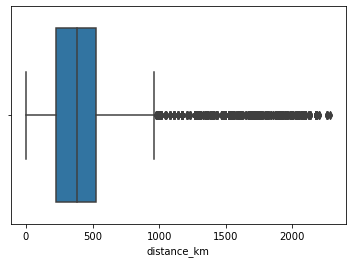

In [10]:
sns.boxplot(x=df["distance_km"])